# 5.Método Cadena Markov-Monte Carlo (MCMC)

In [1]:
using LinearAlgebra
using BenchmarkTools
using SparseArrays
using Random

using Plots
using PyCall
using DataFrames

## Implementación de la función que construye el sistema de ecuaciones de prueba $Ax = b$

In [2]:
function matriz_dispersa(n)
    e = ones(n)
    n2 =Int(n/2)
    diags = [-1,0,1]
    A = Matrix(spdiagm(-1 => -ones(n-1)
        ,0 => 3*ones(n),1 => -ones(n-1)))
    c = spdiagm(0 => ones(n)/2)
    ab = [x for x=1:n]
    ba = [(n+1)-x for x=1:n]
    c = Matrix(permute(c, ba, ab))

    A = A + c
    A[n2+1,n2] = -1
    A[n2,n2+1] = -1
    
    b = zeros(n,1)
    b[1] = 2.5
    b[n] = 2.5
    b[2:n-1] .= [1.5]
    b[n2:n2+1] .= [1]
    return A,b
end

matriz_dispersa (generic function with 1 method)

### Evaluación de parámetros

In [3]:

function preparametros(A,b,ϵ,δ)
    M = diagm(0 => diag(A))
    N = M-A
    T = inv(M) * N
    f = inv(M) * b
    nT, mT = size(T);
    print(nT, mT )

    S = fill(0, nT)
    P = fill(0., nT, mT)
    Pa = P
    [S[i] += 1 for i in 1:nT, j in 1:mT if T[i,j] != 0]
    [P[i,j]= 1/S[i] for i in 1:nT, j in 1:mT if T[i,j] != 0 ]
    Pa = [accumulate(+, P[i, 1:mT]) for i in 1:nT]
    Pi = [1/nT for i in 1:nT];
    Nc = floor((0.6745/δ)^2*((norm(f)^2)/(1-norm(T))^2)) + 1
    return Nc, mT, f, Pa, T, P
end

preparametros (generic function with 1 method)

### Matriz de probabilidad acumulada pre-build con envío de parámetros, type-anotations y view

In [4]:
function mcmc_acc_par_ta(ϵ, Nc, mT, f, Pa, T, P)
    Xs = fill(0., mT)
    for i in 1:mT
        W_0 = 1.0
        for s in 1:Nc
            W = W_0; point = i; X = W_0 * f[i]::Float64
            while abs(W) >= ϵ
                nextpoint  = 1::Int64
                u = rand()
                while u >= Pa[point][nextpoint]::Float64
                    nextpoint = nextpoint + 1::Int64
                end
                    W_new = W *(T[point, nextpoint]/P[point, nextpoint])::Float64
                    X = X + W_new * f[nextpoint]::Float64
                point = nextpoint::Int64
                W = W_new::Float64
            end
        Xs[i] += X::Float64
        end
    end
    Xs = Xs/Nc::Float64
end

mcmc_acc_par_ta (generic function with 1 method)

In [25]:
n = [6, 10, 30, 50]
A,b = matriz_dispersa(n[1])
As = sparse(A,6,6))
bs = sparse(b)
dropzeros(As)
dropzeros(bs)
ϵ = 0.1
δ = 0.1 
(Nc, mT, f, Pa, T, P) = preparametros(A,b,ϵ,δ)
(Ncs, mTs, fs, Pas, Ts, Ps) = preparametros(As,bs,ϵ,δ)

MethodError: [91mMethodError: no method matching sparse(::Array{Float64,2}, ::Tuple{Int64,Int64})[39m
[91m[0mClosest candidates are:[39m
[91m[0m  sparse(::Any, ::Any, [91m::Number[39m) at /build/julia-98cBbp/julia-1.4.1+dfsg/usr/share/julia/stdlib/v1.4/SparseArrays/src/sparsematrix.jl:844[39m
[91m[0m  sparse(::Any, ::Any, [91m::AbstractArray{Bool,1}[39m, [91m::Any[39m, [91m::Any[39m) at /build/julia-98cBbp/julia-1.4.1+dfsg/usr/share/julia/stdlib/v1.4/SparseArrays/src/sparsematrix.jl:852[39m
[91m[0m  sparse(::Any, ::Any, [91m::AbstractArray{T,1} where T[39m) at /build/julia-98cBbp/julia-1.4.1+dfsg/usr/share/julia/stdlib/v1.4/SparseArrays/src/sparsematrix.jl:846[39m
[91m[0m  ...[39m

In [9]:
(A == As)

true

In [10]:
((Nc, mT, f, Pa, P) == (Ncs, mTs, fs, Pas, Ps))

true

In [11]:
@benchmark mcmc_acc_par_ta($ϵ, $Nc, $mT, $f, $Pa, $T, $P)

BenchmarkTools.Trial: 893 samples with 1 evaluation.
 Range (min … max):  5.394 ms …   8.808 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     5.505 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   5.600 ms ± 291.468 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

   █▂▅▄▄▃▂▁                                                    
  █████████▇▄▄▅▄▃▄▃▃▃▃▃▃▃▂▃▃▃▃▁▃▃▂▃▂▂▂▃▃▃▃▃▃▃▃▁▃▂▂▂▃▂▂▁▃▁▂▁▂▂ ▃
  5.39 ms         Histogram: frequency by time        6.43 ms <

 Memory estimate: 256 bytes, allocs estimate: 2.

In [12]:
@benchmark mcmc_acc_par_ta($ϵ, $Ncs, $mT, $fs, $Pas, $Ts, $Ps)

BenchmarkTools.Trial: 753 samples with 1 evaluation.
 Range (min … max):  5.405 ms … 26.076 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     5.517 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   6.639 ms ±  4.493 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

  █▃                                                       ▁  
  ███▇▄▄▁▁▁▁▁▁▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▄▁▁▁▁▁▁▁▁▁▁▁▁█ ▇
  5.4 ms       Histogram: log(frequency) by time       26 ms <

 Memory estimate: 256 bytes, allocs estimate: 2.

In [13]:
X  = @btime mcmc_acc_par_ta($ϵ, $Nc, $mT, $f, $Pa, $T, $P)
Xs = @btime mcmc_acc_par_ta($ϵ, $Ncs, $mTs, $fs, $Pas, $Ts, $Ps)

  5.399 ms (2 allocations: 256 bytes)
  5.398 ms (2 allocations: 256 bytes)


6-element Array{Float64,1}:
 0.99465859587673
 0.9883159755115202
 1.0021780628269485
 0.9984776626731919
 1.014125002565155
 1.0008155539509662

In [14]:
X 

6-element Array{Float64,1}:
 1.0065599726086283
 1.0219244046093603
 1.000907462104228
 1.0042119930422915
 0.9908137118109228
 0.9929341149649071

In [15]:
norm(b-A*X)

0.06456912262293907

In [16]:
norm(bs-As*Xs)

0.055224552571383534

In [17]:
yJacobiJ = []
yJacobiP = []

for i = n
    A,b = matriz_dispersa(i)
    As = sparse(A)
    bs = sparse(b)
    ϵ = 0.1
    δ = 0.1 
    (Nc, mT, f, Pa, T, P) = preparametros(A,b,ϵ,δ)
    (Ncs, mTs, fs, Pas, Ts, Ps) = preparametros(As,bs,ϵ,δ)
    jJ = @benchmark mcmc_acc_par_ta(ϵ, Ncs, mTs, fs, Pas, Ts, Ps) seconds=1
    push!(yJacobiJ, jJ)
    jP = @benchmark mcmc_acc_par_ta(ϵ, Nc, mT, f, Pa, T, P) seconds=1   
    push!(yJacobiP, jP)

end

6666101010103030303050505050

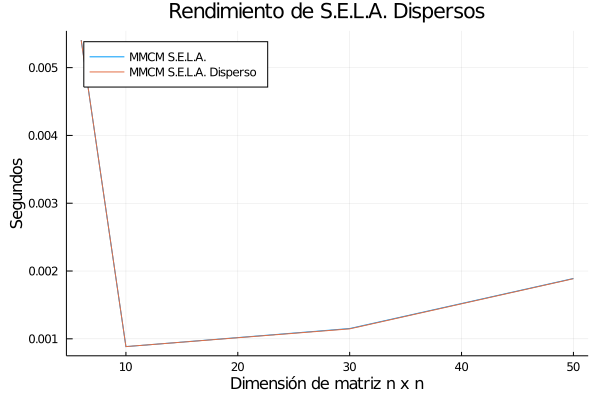

In [18]:
plot(title="Rendimiento de S.E.L.A. Dispersos", legend=:topleft, xaxis="Dimensión de matriz n x n", yaxis="Segundos")
plot!(n, [minimum(yJacobiP[i]).time/10^9  for i=1:size(n)[1]], label="MMCM S.E.L.A.")
plot!(n, [minimum(yJacobiJ[i]).time/10^9  for i=1:size(n)[1]], label="MMCM S.E.L.A. Disperso")